In [41]:
import tensorflow as tf
from IPython.display import display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [42]:
import os
import urllib
import uuid
from datetime import datetime

import pandas as pd

import requests
from PIL import Image

from arize.pandas.logger import Client
from arize.utils.types import Environments, ModelTypes, EmbeddingColumnNames, Schema

In [43]:
files_to_remove = ['.DS_Store']

root_folder = os.path.normpath(os.getcwd() + os.sep + os.pardir)
embeddings_folder = '0_data/embeddings'
embeddings_folder_path = os.path.join(root_folder, embeddings_folder)
beanleaf_files = os.listdir(embeddings_folder_path)
beanleaf_files = [i for i in beanleaf_files if i not in files_to_remove]

beanleaf_files

['beanleaf_validation.csv', 'beanleaf_train.csv', 'beanleaf_production.csv']

In [44]:
def converter(instr):
    return np.fromstring(instr[1:-1],sep=' ')

validation_file = os.path.join(embeddings_folder_path, beanleaf_files[0])
validation_df = pd.read_csv(validation_file, converters={'vector':converter})

training_file = os.path.join(embeddings_folder_path, beanleaf_files[1])
train_df = pd.read_csv(training_file, converters={'vector':converter})

# for now use cat & dog data as production data (WIP to create prod dataset)
production_file = os.path.join(embeddings_folder_path, beanleaf_files[2])
production_df = pd.read_csv(production_file, converters={'vector':converter})

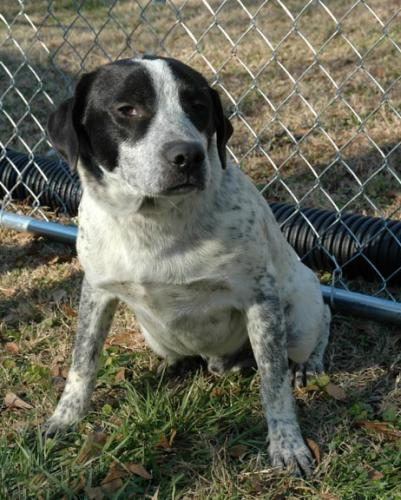

In [45]:
Image.open(production_df.iloc[0]['url'])

In [46]:
SPACE_KEY = '53bd436'
API_KEY = '9178a0748dc2c31e24f'
arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)
model_id = 'beanleaf-disease-classifier'
model_version = '1.0'
model_type = ModelTypes.SCORE_CATEGORICAL
if SPACE_KEY == 'SPACE_KEY' or API_KEY == 'API_KEY':
    raise ValueError('❌ NEED TO CHANGE SPACE AND/OR API_KEY')
else:
    print('✅ Import and Setup Arize Client Done! Now we can start using Arize!')

✅ Import and Setup Arize Client Done! Now we can start using Arize!


In [47]:
def add_prediction_id(df):
    return [str(uuid.uuid4()) for _ in range(df.shape[0])]

In [48]:
train_df['prediction_id'] = add_prediction_id(train_df)
validation_df['prediction_id'] = add_prediction_id(validation_df)
production_df['prediction_id'] = add_prediction_id(production_df)

In [49]:
embedding_features = [
    EmbeddingColumnNames(
        vector_column_name='vector',  # Will be name of embedding feature in the app
        link_to_data_column_name='url',
    ),
]

# Define a Schema() object for Arize to pick up data from the correct columns for logging
schema = Schema(
    prediction_id_column_name='prediction_id',
    timestamp_column_name='prediction_ts',
    prediction_label_column_name='predicted_label',
    actual_label_column_name='actual_label',
    prediction_score_column_name='score',
    embedding_feature_column_names=embedding_features
)

In [50]:
# Logging Training DataFrame
response = arize_client.log(
    dataframe=train_df,
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    environment=Environments.TRAINING,
    schema=schema,
    sync=True
)


# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"❌ logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged training set to Arize")

Success! Check out your data at https://app.arize.com/organizations/QWNjb3VudE9yZ2FuaXphdGlvbjo4OTE=/spaces/U3BhY2U6OTMz/models/modelName/beanleaf-disease-classifier?selectedTab=dataIngestion
✅ You have successfully logged training set to Arize


In [51]:
# Logging Validation DataFrame
response = arize_client.log(
    dataframe=validation_df,
    model_id=model_id,
    model_version=model_version,
    batch_id='validation',
    model_type=model_type,
    environment=Environments.VALIDATION,
    schema=schema,
    sync=True
)

# If successful, the server will return a status_code of 200
if response.status_code != 200:
    print(f"❌ logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged training set to Arize")


Success! Check out your data at https://app.arize.com/organizations/QWNjb3VudE9yZ2FuaXphdGlvbjo4OTE=/spaces/U3BhY2U6OTMz/models/modelName/beanleaf-disease-classifier?selectedTab=dataIngestion
✅ You have successfully logged training set to Arize


In [52]:
# Define a Schema() object for Arize to pick up data from the correct columns for logging
prod_schema = Schema(
    prediction_id_column_name='prediction_id',
    timestamp_column_name='prediction_ts',
    prediction_label_column_name='predicted_label',
    prediction_score_column_name='score',
    embedding_feature_column_names=embedding_features
)

# Logging Production DataFrame
response = arize_client.log(
    dataframe=production_df,
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    environment=Environments.PRODUCTION,
    schema=prod_schema,
    sync=True
)

if response.status_code != 200:
    print(f"❌ logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged production set to Arize")

Success! Check out your data at https://app.arize.com/organizations/QWNjb3VudE9yZ2FuaXphdGlvbjo4OTE=/spaces/U3BhY2U6OTMz/models/modelName/beanleaf-disease-classifier?selectedTab=dataIngestion
✅ You have successfully logged production set to Arize
